In [ ]:
import sys
import os
from pathlib import Path

sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import umap
import matplotlib.pyplot as plt


from utils.data import download_mnist_data, get_mnist_image_np_arrays

# Load MNIST images

In [2]:
download_mnist_data()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1 22.0M    1  318k    0     0   351k      0  0:01:04 --:--:--  0:01:04  351k

Unzipping dataset...
Deleting zip...
Done


100 22.0M  100 22.0M    0     0  13.1M      0  0:00:01  0:00:01 --:--:-- 28.1M


In [3]:
train_images, test_images = get_mnist_image_np_arrays()

# UMAP embeddings

In [4]:
embedding_dim = 2

flat_train_images = train_images.reshape(train_images.shape[0], -1)
reducer = umap.UMAP(n_components=embedding_dim)
embeddings = reducer.fit_transform(flat_train_images)


In [5]:
# Save embeddings to a file
project_dir = Path("..").resolve()
embeddings_file = (
    project_dir
    / "data"
    / "mnist"
    / "umap_embeddings"
    / f"embeddings_d{embedding_dim}.npy"
)
embeddings_file.parent.mkdir(parents=True, exist_ok=True)
np.save(embeddings_file, embeddings)


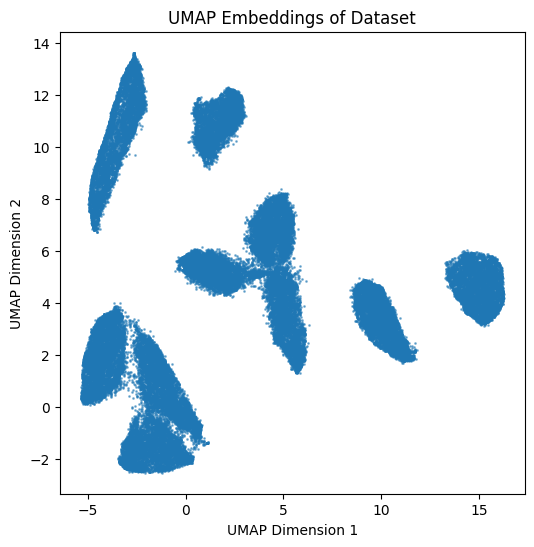

In [8]:
# Plot embeddings
plt.figure(figsize=(6, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], s=1, alpha=0.5)
plt.title("UMAP Embeddings of Dataset")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()
